In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from prophet import Prophet
import optuna
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
data = pd.read_csv(r'Supermart Grocery Sales - Retail Analytics Dataset.csv')
data.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [22]:
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y', errors='coerce')

# Drop rows with invalid dates
data = data.dropna(subset=['Order Date'])

data['Year'] = data['Order Date'].dt.year
data['Month'] = data['Order Date'].dt.month
data['Day'] = data['Order Date'].dt.day
data['DayOfWeek'] = data['Order Date'].dt.dayofweek
data['WeekOfYear'] = data['Order Date'].dt.isocalendar().week

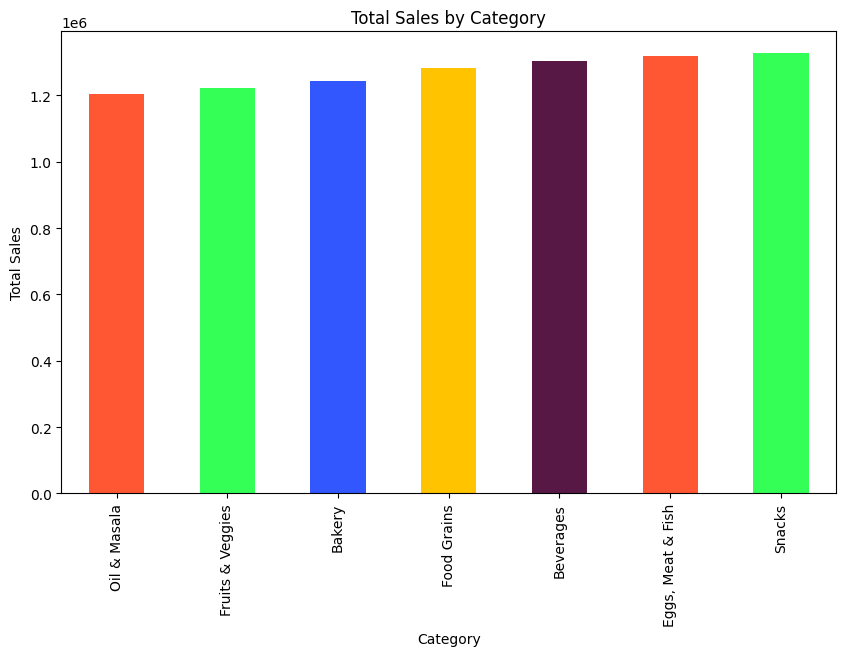

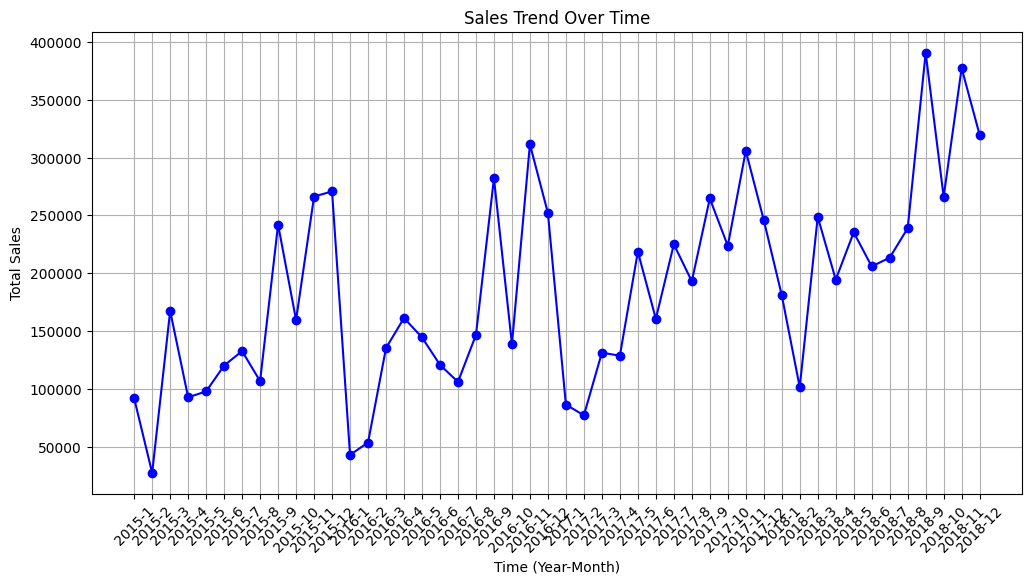

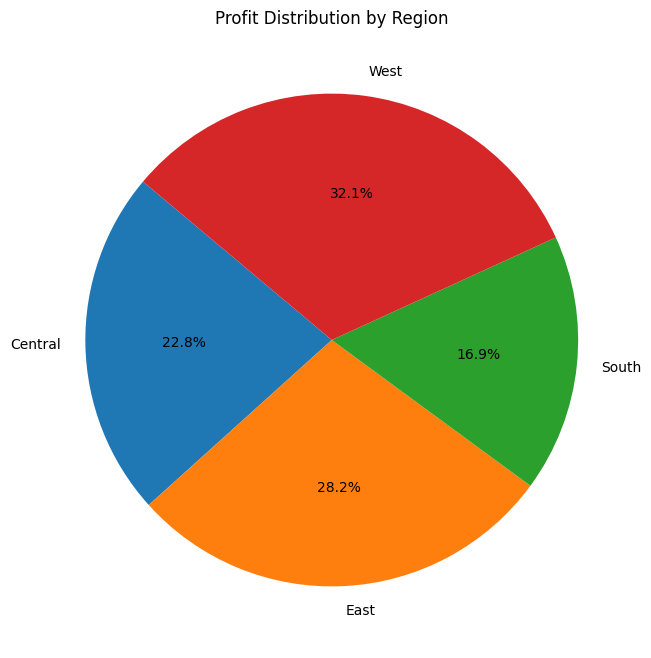

In [23]:
category_sales = data.groupby('Category')['Sales'].sum().sort_values()
colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#581845']
category_sales.plot(kind='bar', figsize=(10, 6), title='Total Sales by Category', color=colors)
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.show()

sales_over_time = data.groupby(['Year', 'Month'])['Sales'].sum().reset_index()
sales_over_time['Time'] = sales_over_time['Year'].astype(str) + '-' + sales_over_time['Month'].astype(str)
plt.figure(figsize=(12, 6))
plt.plot(sales_over_time['Time'], sales_over_time['Sales'], marker='o', linestyle='-', color='blue')
plt.title('Sales Trend Over Time')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid()
plt.show()

data.groupby('Region')['Profit'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8, 8), title='Profit Distribution by Region')
plt.ylabel('')
plt.show()

In [24]:
for lag in range(1, 4):
    data[f'Lag_{lag}'] = data.groupby(['Category', 'Region'])['Sales'].shift(lag)

data['Rolling_Avg_3'] = data.groupby(['Category', 'Region'])['Sales'].transform(lambda x: x.rolling(3, min_periods=1).mean())
data['Rolling_Avg_6'] = data.groupby(['Category', 'Region'])['Sales'].transform(lambda x: x.rolling(6, min_periods=1).mean())
data['Rolling_Std_3'] = data.groupby(['Category', 'Region'])['Sales'].transform(lambda x: x.rolling(3, min_periods=1).std())
data['Expanding_Mean'] = data.groupby(['Category', 'Region'])['Sales'].transform(lambda x: x.expanding().mean())

# Drop rows with NaN values after lagged feature creation
data = data.dropna(subset=['Lag_1', 'Lag_2', 'Lag_3'])

In [25]:
data['Region_Avg_Sales'] = data.groupby('Region')['Sales'].transform('mean')
data['Category_Avg_Sales'] = data.groupby('Category')['Sales'].transform('mean')
data['Discount_Profit_Interaction'] = data['Discount'] * data['Profit']
data['Sine_Month'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Cosine_Month'] = np.cos(2 * np.pi * data['Month'] / 12)

In [26]:
X = data[['Category', 'Sub Category', 'Region', 'State', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear',
          'Discount', 'Profit', 'Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Avg_3', 'Rolling_Avg_6',
          'Rolling_Std_3', 'Expanding_Mean', 'Region_Avg_Sales', 'Category_Avg_Sales', 'Discount_Profit_Interaction',
          'Sine_Month', 'Cosine_Month']]
y = data['Sales']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [28]:
categorical_features = ['Category', 'Sub Category', 'Region', 'State']
numerical_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'Discount', 'Profit', 'Lag_1', 'Lag_2',
                       'Lag_3', 'Rolling_Avg_3', 'Rolling_Avg_6', 'Rolling_Std_3', 'Expanding_Mean',
                       'Region_Avg_Sales', 'Category_Avg_Sales', 'Discount_Profit_Interaction',
                       'Sine_Month', 'Cosine_Month']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [29]:
def train_prophet(data):
    prophet_data = data[['Order Date', 'Sales']].rename(columns={'Order Date': 'ds', 'Sales': 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(prophet_data)
    future = model.make_future_dataframe(periods=30)  # Predict for the next 30 days
    forecast = model.predict(future)
    return forecast

# Train Prophet model
prophet_forecast = train_prophet(data)

10:11:47 - cmdstanpy - INFO - Chain [1] start processing
10:11:47 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42
    }

    model = lgb.LGBMRegressor(**params)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False)

In [31]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2024-12-15 10:11:48,052] A new study created in memory with name: no-name-9aef87d5-1729-451c-b49a-d38b9635b1c7
c:\Users\sravan\Downloads\infosys\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-15 10:11:49,045] Trial 4 finished with value: 193.58379818500492 and parameters: {'n_estimators': 214, 'max_depth': 3, 'learning_rate': 0.030036880079989267, 'subsample': 0.8777753214561679, 'colsample_bytree': 0.9919491390723743, 'reg_alpha': 2.1572927424334964, 'reg_lambda': 7.939178278308747}. Best is trial 4 with value: 193.58379818500492.
c:\Users\sravan\Downloads\infosys\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_

In [32]:
best_params = study.best_params
final_model = lgb.LGBMRegressor(**best_params)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', final_model)
])

final_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2520
[LightGBM] [Info] Number of data points in the train set: 4694, number of used features: 53
[LightGBM] [Info] Start training from score 1496.782275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Month', 'Day',
                                                   'DayOfWeek', 'WeekOfYear',
                                                   'Discount', 'Profit',
                                                   'Lag_1', 'Lag_2', 'Lag_3',
                                                   'Rolling_Avg_3',
                                                   'Rolling_Avg_6',
                                                   'Rolling_Std_3',
                                                   'Expanding_Mean',
                                                   'Region_Avg_Sales',
                                                   'Category_Avg_Sales',
                                                   'Discount_Profit_Interaction',
                                                   'Sine_Month',
                                                   'Cosine_Month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'Sub Category',
                                                   'Region', 'State'])])),
                ('model',
                 LGBMRegressor(colsample_bytree=0.942106735638911,
                               learning_rate=0.14969407742320223, max_depth=3,
                               n_estimators=755, reg_alpha=1.8835353991079316,
                               reg_lambda=6.963096567986013,
                               subsample=0.653984306979593))])

In [33]:
y_train_pred = final_pipeline.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)

# Display Training Results
print("Training Set Evaluation Results:")
print(f"MAE: {train_mae}")
print(f"RMSE: {train_rmse}")
print(f"R2: {train_r2}")

Training Set Evaluation Results:
MAE: 21.420782549353515
RMSE: 27.62366812478881
R2: 0.9977348034755954


c:\Users\sravan\Downloads\infosys\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('prophet_forecast.csv', index=False)

In [35]:
y_test_pred = final_pipeline.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Evaluation Results:")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")
print(f"R2: {test_r2}")

Test Set Evaluation Results:
MAE: 38.61614617602961
RMSE: 48.71580747433249
R2: 0.992908565628661


c:\Users\sravan\Downloads\infosys\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


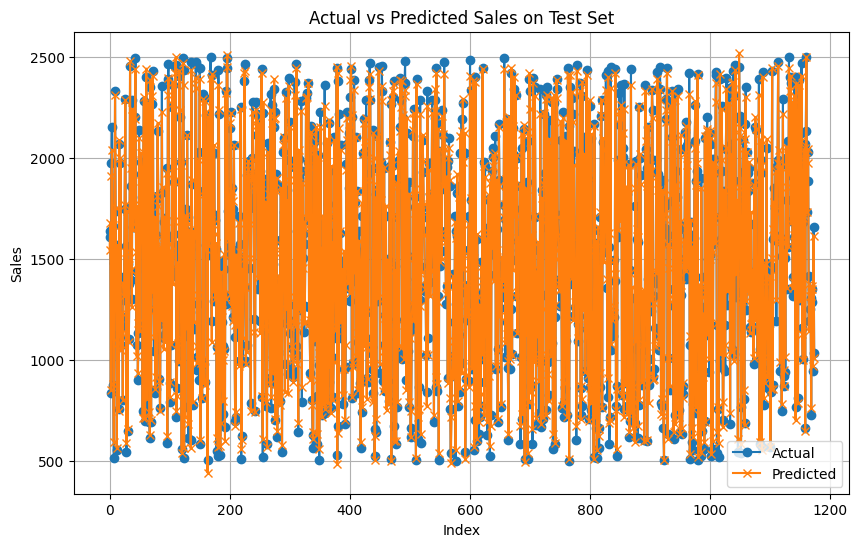

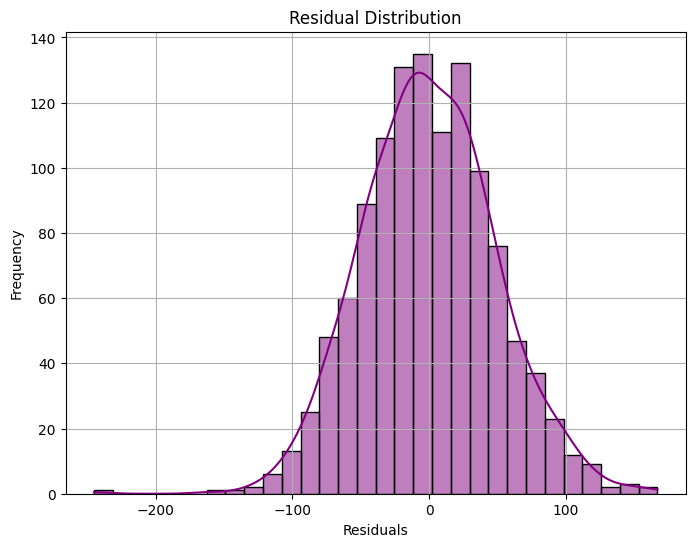

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_test_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Sales on Test Set')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

# Residual Plot
residuals = y_test.values - y_test_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()
